In [1]:
import os
from pathlib import Path
from functools import partial
from typing import Any, cast

import pandas as pd
import torch
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

from src.model import Autoencoder
from src.datasets.mvtec_ad import MVTecAD
from src.persistence import load_model
from src.preprocessing import InferencePreprocessing

DATASET_DIR = Path(os.environ["MVTEC_DATASET_DIR"])
SAVED_MODEL = Path(os.environ["MVTEC_SAVED_MODEL"])
HISTORY_FILE = Path(os.environ["MVTEC_HISTORY_FILE"])

<Axes: xlabel='epoch'>

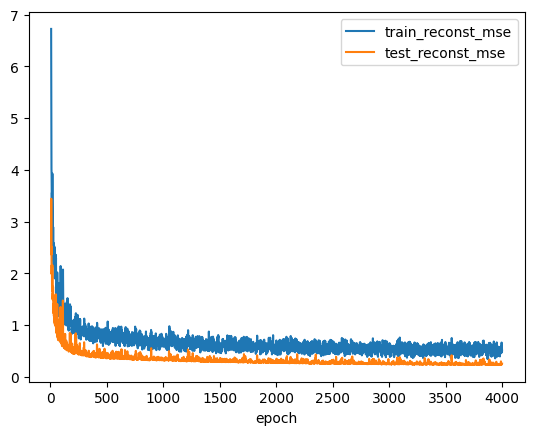

In [2]:
df_history = pd.read_csv(HISTORY_FILE)
df_history[df_history["epoch"] > 5].plot(x="epoch", y=["train_reconst_mse", "test_reconst_mse"])

In [3]:
def binary_labels(label: torch.Tensor) -> torch.Tensor:
    return torch.tensor(0) if label == 0 else torch.tensor(1)

create_ds = partial(
        MVTecAD,
        dataset_dir=DATASET_DIR,
        object=os.environ["MVTEC_OBJECT"],
        sample_transform=InferencePreprocessing(
            target_img_width=int(os.environ["IMAGE_WIDTH"]),
            target_img_height=int(os.environ["IMAGE_HEIGHT"]),
        ),
        target_transform=binary_labels,
    )
ds_train, ds_test = create_ds(training_set=True), create_ds(training_set=False)

In [4]:
model = Autoencoder()
load_model(model, SAVED_MODEL)
model.eval()

Autoencoder(
  (encoder): Encoder(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (5): ReLU()
    (6): Conv2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (7): ReLU()
  )
  (decoder): Decoder(
    (0): ConvTranspose2d(128, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), output_padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [5]:
def transfer_function(image: torch.Tensor, scale: float, shift: float) -> torch.Tensor:
        return torch.sigmoid(image * scale - shift)

In [6]:
img_original, _ = cast(torch.Tensor, ds_test[52])
with torch.no_grad():
    img_reconstr = cast(torch.Tensor, model(img_original))

def plot_images(scale: float, shift: float) -> None:
    img_diff = (img_original - img_reconstr).abs()
    img_diff = transfer_function(img_diff, scale, shift)

    fig = plt.figure(figsize=(10, 10), constrained_layout=True)
    gs = fig.add_gridspec(4, 4)
    ax_original = fig.add_subplot(gs[:2, :2])
    ax_reconstr = fig.add_subplot(gs[:2, 2:])
    ax_hist = fig.add_subplot(gs[2:3, :2])
    ax_sigmoid = fig.add_subplot(gs[3:, :2])
    ax_diff = fig.add_subplot(gs[2:, 2:])

    def plot_image(ax, img: torch.Tensor, title: str, cmap: str) -> None:
        ax.imshow(img.movedim(0, -1), cmap=cmap, vmin=0, vmax=1)
        ax.set_title(title)

    plot_image(ax_original, img_original, title="Original", cmap="gray")
    plot_image(ax_reconstr, img_reconstr, title="Reconstructed", cmap="gray")
    plot_image(ax_diff, img_diff, title="Difference", cmap="hot")

    ax_hist.hist(img_diff.flatten(), density=True)
    ax_hist.set_title("Value Distribution")

    xs = torch.linspace(*ax_hist.get_xlim(), 10000)
    ys = transfer_function(xs, scale, shift)
    ax_sigmoid.plot(xs, ys)
    ax_sigmoid.set_title("Transfer Function")


interact(plot_images, scale=FloatSlider(value=100, min=0, max=200), shift=FloatSlider(value=5, min=-20, max=20))

interactive(children=(FloatSlider(value=100.0, description='scale', max=200.0), FloatSlider(value=5.0, descrip…

<function __main__.plot_images(scale: float, shift: float) -> None>

In [7]:
data: dict[str, Any] = {"set": [], "idx": [], "loss": [], "label": []}

def perform_inference(ds: MVTecAD, set_name: str) -> None:
    loss_fn = torch.nn.L1Loss()

    for idx, (original, label) in enumerate(ds):
        with torch.no_grad():
            original = original.unsqueeze(dim=0)

            reconstructed = model(original)
            reconstructed = transfer_function(reconstructed, scale=90, shift=9)
            loss = loss_fn(reconstructed, original)

            data["set"].append(set_name)
            data["idx"].append(idx)
            data["loss"].append(loss.item())
            data["label"].append(int(label))

perform_inference(ds_train, "train")
perform_inference(ds_test, "test")

df = pd.DataFrame.from_dict(data)

In [8]:
print(df[["set", "loss"]].groupby("set").describe())

        loss                                                              \
       count      mean       std       min       25%       50%       75%   
set                                                                        
test   110.0  0.780237  0.011910  0.736921  0.775911  0.782322  0.787863   
train  391.0  0.759437  0.030533  0.562514  0.746838  0.768018  0.779430   

                 
            max  
set              
test   0.801644  
train  0.806466  


In [9]:
decision_boundary = df[df["set"] == "train"]["loss"].quantile(0.75)
df["prediction"] = 0
df.loc[df["loss"] > decision_boundary, "prediction"] = 1

In [10]:
df_test = df[df["set"] == "test"]

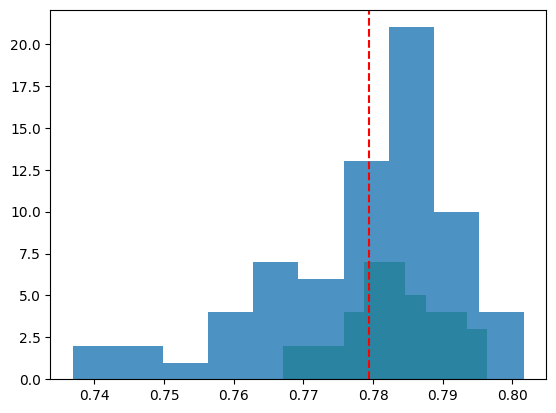

In [11]:
plt.hist(df_test[df_test["label"] == 0]["loss"], color="tab:green", alpha=0.8)
plt.hist(df_test[df_test["label"] == 1]["loss"], color="tab:blue", alpha=0.8)
plt.axvline(x=decision_boundary, color="r", linestyle="--")

In [12]:
accuracy = sum(df_test["label"] == df_test["prediction"]) / len(df_test)
accuracy

0.44545454545454544

In [13]:
df.sort_values(by="loss", ascending=False).head(10)

,set,idx,loss,label,prediction
138,train,138,0.806466,0,1
253,train,253,0.803709,0,1
433,test,42,0.801644,1,1
143,train,143,0.800819,0,1
211,train,211,0.800364,0,1
299,train,299,0.798696,0,1
213,train,213,0.798286,0,1
441,test,50,0.796669,1,1
420,test,29,0.796360,0,1
463,test,72,0.796184,1,1
